In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Brain


/content/drive/MyDrive/Brain


In [3]:
!pwd

/content/drive/MyDrive/Brain


In [4]:
#!unzip BrainT.zip

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

2023-09-23 21:34:20.827825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 21:34:21.835477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
data_dir="Training"

In [6]:
test_dir='Testing'

In [7]:
#creating a list of filepaths and labels so that we can easy map them togehter
filepaths=[]
labels=[]
folders=os.listdir(test_dir)
for folder in folders:
   f_path = os.path.join(test_dir , folder)
   filelists = os.listdir(f_path)

   for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(folder)

In [8]:
filepaths[0]

'Testing/glioma/Te-gl_0045.jpg'

In [34]:
import pandas as pd
#making test_df where a img name next to its detection
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [36]:
test_df.head()

,filepaths,label
0,Training/glioma/Tr-gl_0591.jpg,glioma
1,Training/glioma/Tr-gl_0878.jpg,glioma
2,Training/glioma/Tr-gl_0917.jpg,glioma
3,Training/glioma/Tr-gl_0729.jpg,glioma
4,Training/glioma/Tr-gl_0582.jpg,glioma


In [10]:
#making training as test dataset out of test folder 
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [11]:
#doing smae what we did with train data
filepaths =[]
labels = []

folds = os.listdir(data_dir)

for fold in folds:
    f_path = os.path.join(data_dir , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [12]:
img_size = (224 ,244)
batch_size = 100
tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [13]:
#class_indices provide prediction label
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
# images , labels = next(train_gen)

# plt.figure(figsize= (20,20))

# for i in range(20):
#     plt.subplot(4,4,i+1)
#     image = images[i] / 255
#     plt.imshow(image)
#     index = np.argmax(labels[i])
#     class_name = classes[index]
#     plt.title(class_name , color = 'blue' , fontsize= 12)
#     plt.axis('off')
# plt.show();

In [37]:
gen_dict

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [14]:
#define image shape
img_shape = (img_size[0] , img_size[1] , 3)
#number of classess
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 1109

In [16]:
histtory=model.fit(train_gen,epochs=20,verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/20
58/58 [==============================] - 1769s 30s/step - loss: 6.7365 - accuracy: 0.8796 - val_loss: 6.1491 - val_accuracy: 0.6504
Epoch 2/20
58/58 [==============================] - 23s 396ms/step - loss: 4.2301 - accuracy: 0.9758 - val_loss: 3.6484 - val_accuracy: 0.9069
Epoch 3/20
58/58 [==============================] - 23s 397ms/step - loss: 2.9763 - accuracy: 0.9844 - val_loss: 2.5990 - val_accuracy: 0.9542
Epoch 4/20
58/58 [==============================] - 23s 397ms/step - loss: 2.1668 - accuracy: 0.9939 - val_loss: 1.9113 - val_accuracy: 0.9725
Epoch 5/20
58/58 [==============================] - 23s 398ms/step - loss: 1.6189 - accuracy: 0.9960 - val_loss: 1.4313 - val_accuracy: 0.9802
Epoch 6/20
58/58 [==============================] - 23s 399ms/step - loss: 1.2362 - accuracy: 0.9953 - val_loss: 1.0985 - val_accuracy: 0.9847
Epoch 7/20
58/58 [==============================] - 23s 397ms/step - loss: 0.9548 - accuracy: 0.9979 - val_loss: 0.8630 - val_accuracy: 0.9786

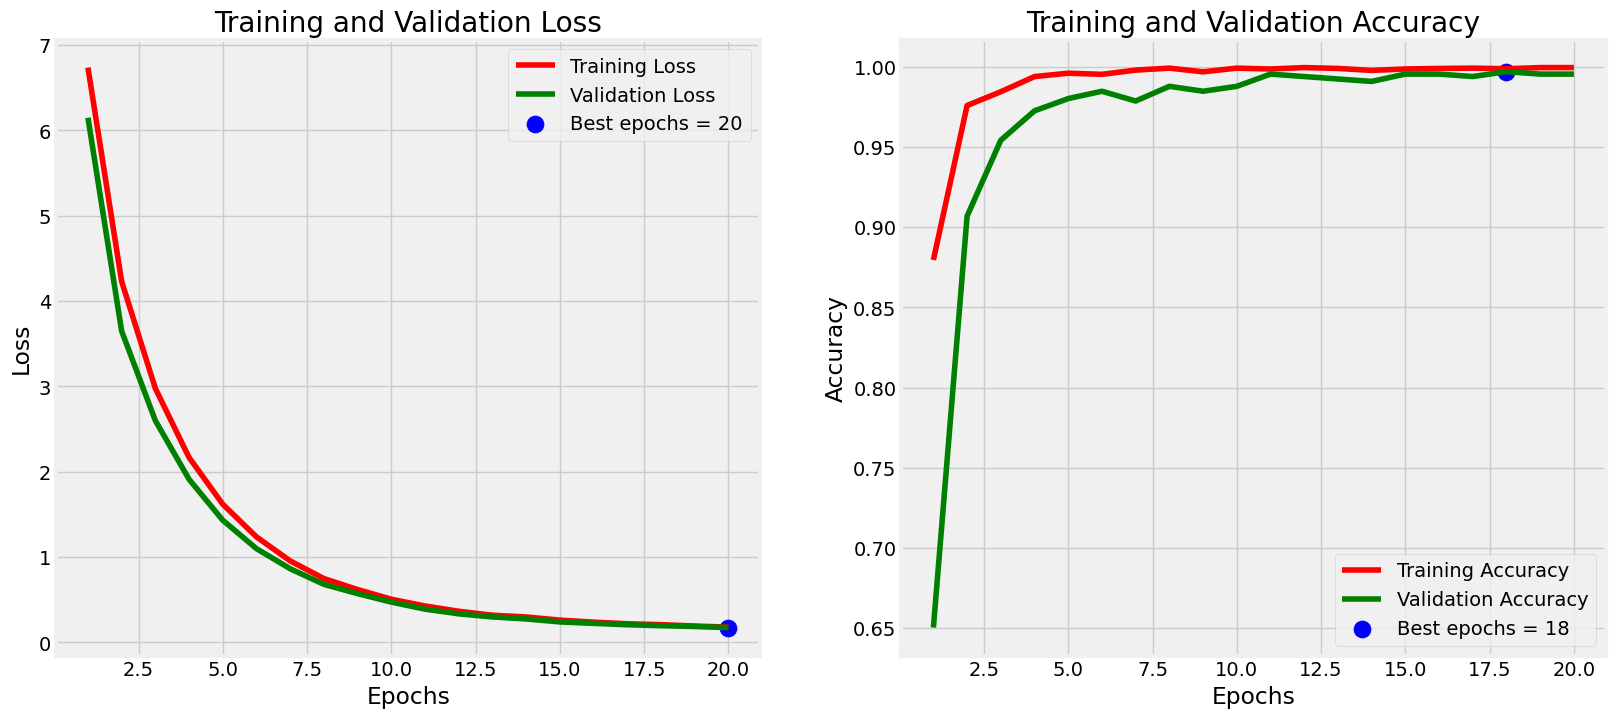

In [19]:
import numpy as np
train_acc = histtory.history['accuracy']
train_loss = histtory.history['loss']

val_acc = histtory.history['val_accuracy']
val_loss = histtory.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [21]:
!pip install h5py pyymal


ERROR: Could not find a version that satisfies the requirement pyymal (from versions: none)
ERROR: No matching distribution found for pyymal


In [23]:
save_dir = 'Save_Model'

# Save the model in different formats
tf.saved_model.save(model, save_dir)  # Save in the default TensorFlow SavedModel format


TypeError: ignored

In [24]:
model.save(save_dir,"h5Weigths/weights.h5")

In [25]:
dir='savemodel/basicModel'
tf.saved_model.save(model, save_dir)

In [27]:
model.save('nn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
#LOading model

model=tf.keras.models.load_model('Saved_Model')

2023-09-23 21:34:41.133844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 21:34:41.501546: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [30]:
import numpy as np
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

/tmp/ipykernel_20424/2520681738.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


In [31]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       151
  meningioma       0.97      0.99      0.98       153
     notumor       1.00      1.00      1.00       190
   pituitary       0.99      0.99      0.99       162

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



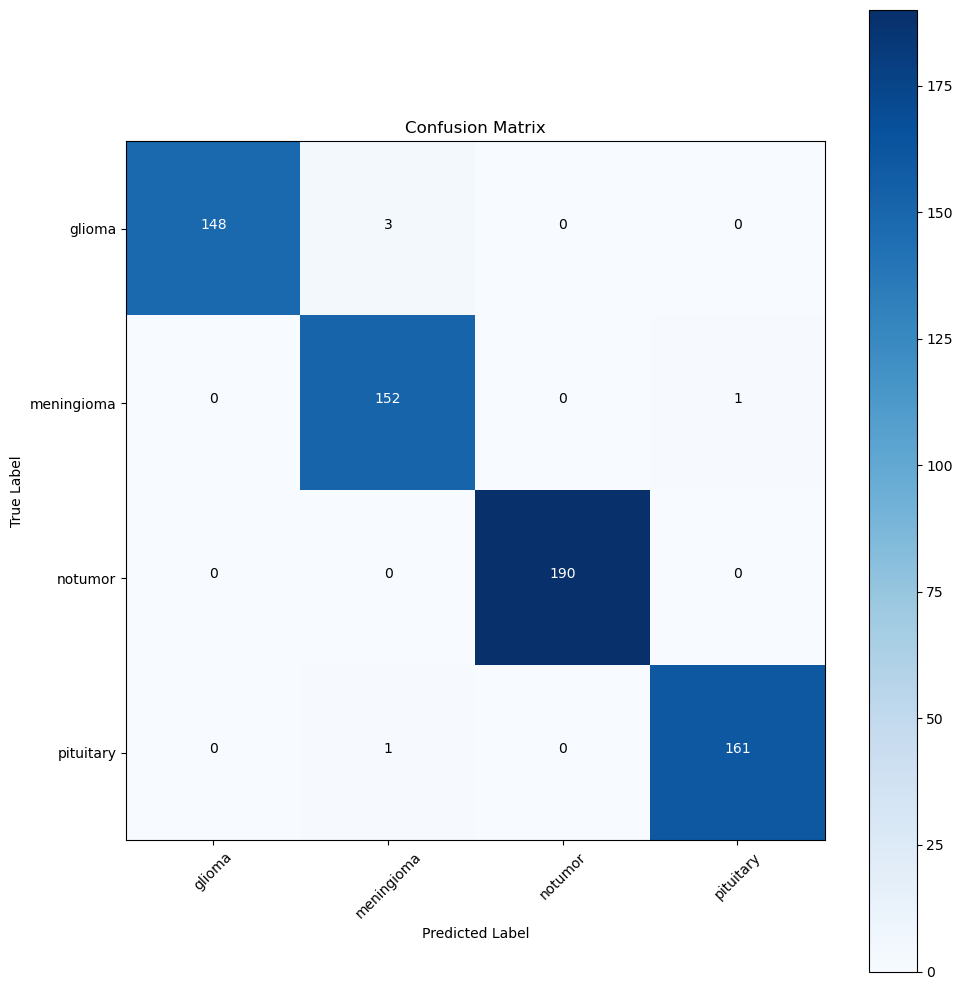

In [32]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [3]:
Tf_lite_model_name='tf_lite_model_BrainTumor.tf.lite'
tf_lite_converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=tf_lite_converter.convert()
open(Tf_lite_model_name, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprax4h3q7/assets


INFO:tensorflow:Assets written to: /tmp/tmprax4h3q7/assets
2023-09-23 21:36:08.543881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-23 21:36:08.543904: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-23 21:36:08.545944: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprax4h3q7
2023-09-23 21:36:08.598086: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-23 21:36:08.598117: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmprax4h3q7
2023-09-23 21:36:08.727045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-23 21:36:08.775684: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-23 21:36:09.547060: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

44338140